<a href="https://colab.research.google.com/github/WilliamShengYangHuang/Inter-typal-Research/blob/main/PHD_Typal_Fusion_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classication on Own Datasets 
Created by William Huang (ucfnhua@ucl.ac.uk) based on  [fchollet](https://twitter.com/fchollet)'s  Xception development

**Date created:** 2020/04/27<br>
**Last modified:** 2021/07/11<br>


## Introduction

This example shows how to do image classification from scratch, starting from JPEG
image files on disk, without leveraging pre-trained weights or a pre-made Keras
Application model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary
 classification dataset.

We use the `image_dataset_from_directory` utility to generate the datasets, and
we use Keras image preprocessing layers for image standardization and data augmentation.


## Setup


In [ ]:
# !apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from google.colab import drive
import plotly.express as px

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


## List devices

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15676121550570030961
 xla_global_id: -1]

## Load Data



Now we have a `PetImages` folder which contain two subfolders, `Cat` and `Dog`. Each
 subfolder contains image files for each category.


In [ ]:
# Place the dataset in your Google Drive 

path = "/content/drive/My Drive/creative_cycleland/facade/dataset+bg" #@param{type:"string"}
print('path = ' + path)

os.chdir(path)
os.listdir(path)

!ls
!ls dataset

path = /content/drive/My Drive/creative_cycleland/facade/dataset+bg
cultural  recycling
ls: cannot access 'dataset': No such file or directory


### Name the Labels

In [ ]:
class_0 = 'cultural' #@param{type:"string"}
# folder name for class 0 images

class_1 = 'recycling' #@param{type:"string"}
# folder name for class 1 images

### Filter out corrupted images

When working with lots of real-world image data, corrupted images are a common
occurence. Let's filter out badly-encoded images that do not feature the string "JFIF"
 in their header.


In [ ]:
#@title
"""
num_skipped = 0
for folder_name in (class_0, class_1):
    folder_path = os.path.join(path, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)
"""

'\nnum_skipped = 0\nfor folder_name in (class_0, class_1):\n    folder_path = os.path.join(path, folder_name)\n    for fname in os.listdir(folder_path):\n        fpath = os.path.join(folder_path, fname)\n        try:\n            fobj = open(fpath, "rb")\n            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)\n        finally:\n            fobj.close()\n\n        if not is_jfif:\n            num_skipped += 1\n            # Delete corrupted image\n            os.remove(fpath)\n\nprint("Deleted %d images" % num_skipped)\n'

## Create Dataset


In [ ]:
training_set_name = 'training' #@param{type:"string"}
validation_set_name = 'validation' #@param{type:"string"}

In [ ]:
image_size = (256, 256)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.1,
    subset=training_set_name,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.1,
    subset=validation_set_name,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 100 files belonging to 2 classes.
Using 90 files for training.
Found 100 files belonging to 2 classes.
Using 10 files for validation.


## Visualise the Data


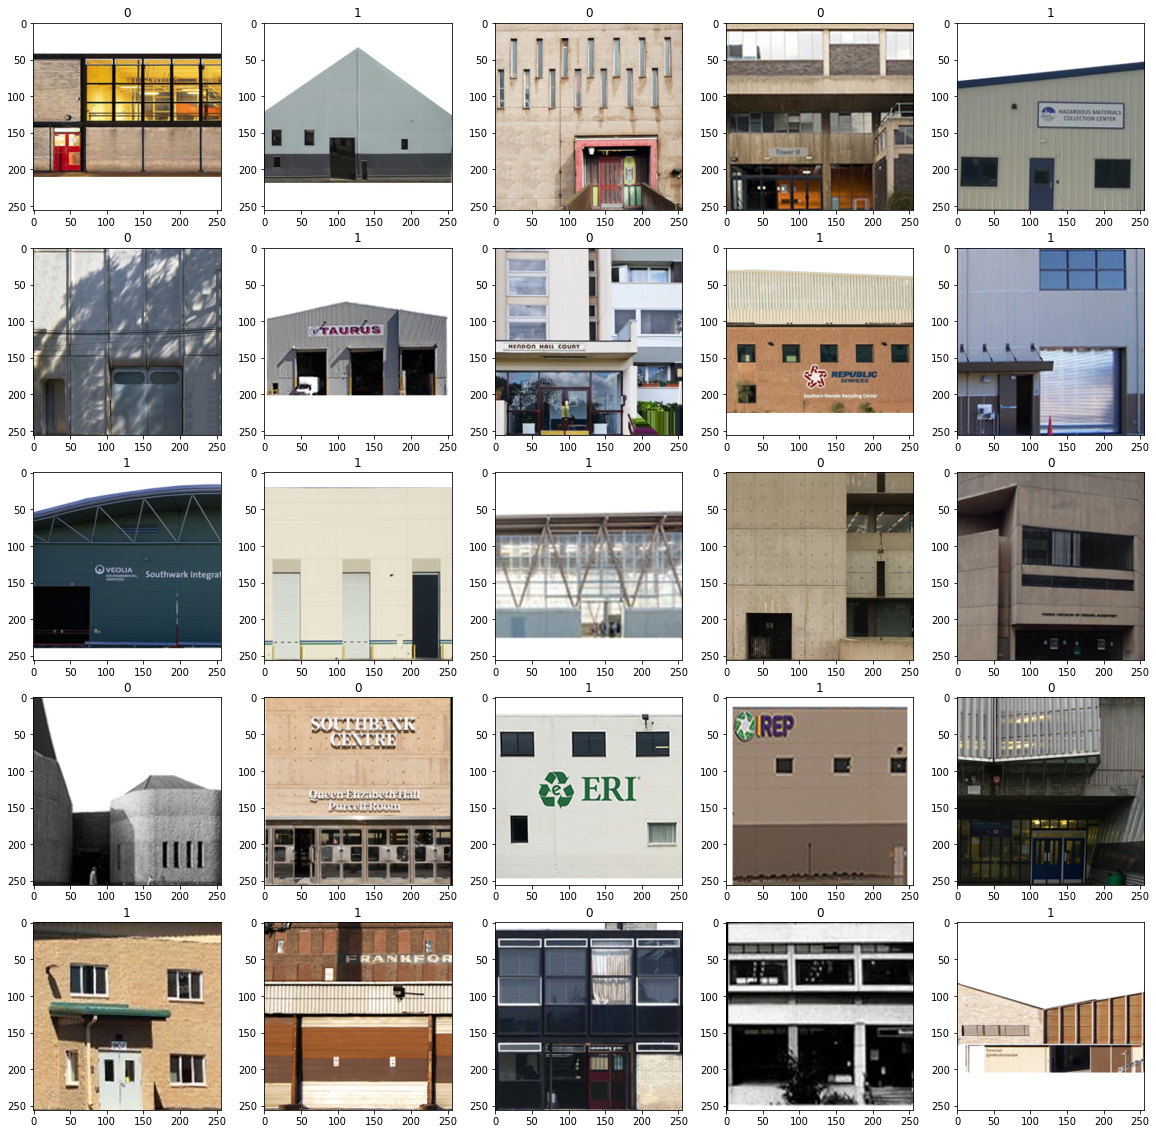

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)          
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]), fontsize=12)
        plt.axis("on")

## Image Data Augmentation

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to the
training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
 overfitting.


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

Let's visualize what the augmented samples look like, by applying `data_augmentation`
 repeatedly to the first image in the dataset:


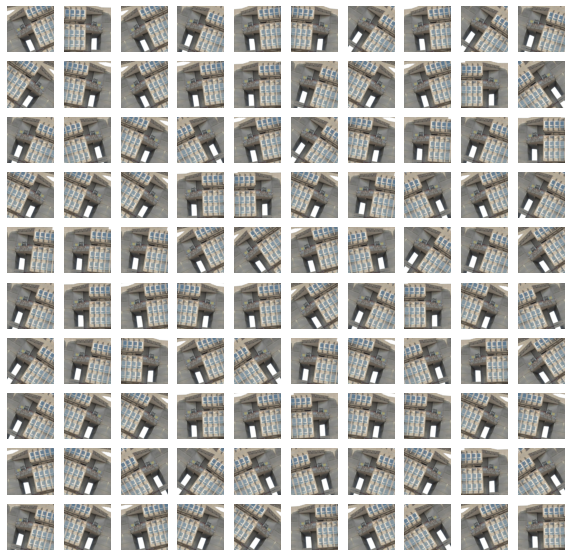

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(100):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(10, 10, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Standardising the Data

Our image are already in a standard size (180x180), as they are being yielded as
contiguous `float32` batches by our dataset. However, their RGB channel values are in
 the `[0, 255]` range. This is not ideal for a neural network;
in general you should seek to make your input values small. Here, we will
standardize values to be in the `[0, 1]` by using a `Rescaling` layer at the start of
 our model.


## Two Options to Preprocess the Data



There are two ways you could be using the `data_augmentation` preprocessor:

**Option 1: Make it part of the model**, like this:

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(1./255)(x)
...  # Rest of the model
```

With this option, your data augmentation will happen *on device*, synchronously
with the rest of the model execution, meaning that it will benefit from GPU
 acceleration.

Note that data augmentation is inactive at test time, so the input samples will only be
 augmented during `fit()`, not when calling `evaluate()` or `predict()`.

If you're training on GPU, this is the better option.

**Option 2: apply it to the dataset**, so as to obtain a dataset that yields batches of
 augmented images, like this:

```python
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))
```

With this option, your data augmentation will happen **on CPU**, asynchronously, and will
 be buffered before going into the model.

If you're training on CPU, this is the better option, since it makes data augmentation
 asynchronous and non-blocking.

In our case, we'll go with the first option.


## Configure the Dataset for Performance

Let's make sure to use buffered prefetching so we can yield data from disk without
 having I/O becoming blocking:


In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## Build a Xception Model 

We'll build a small version of the Xception network. We haven't particularly tried to
optimize the architecture; if you want to do a systematic search for the best model
 configuration, consider using
[Keras Tuner](https://github.com/keras-team/keras-tuner).

Note that:

- We start the model with the `data_augmentation` preprocessor, followed by a
 `Rescaling` layer.
- We include a `Dropout` layer before the final classification layer.


In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
    x = layers.Dropout(0.5)(x)
    
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
#keras.utils.plot_model(model, show_shapes=True)


## Train the Model


In [ ]:
EPOCHS = 5000 #@param {type:"slider", min:0, max:5000, step:10} 

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=EPOCHS, callbacks=callbacks, validation_data=val_ds,
)


Streaming output truncated to the last 5000 lines.
3/3 [==============================] - 10s 3s/step - loss: 1.4768e-05 - accuracy: 1.0000 - val_loss: 0.0206 - val_accuracy: 1.0000
Epoch 2502/5000
3/3 [==============================] - 10s 3s/step - loss: 8.1780e-07 - accuracy: 1.0000 - val_loss: 0.0208 - val_accuracy: 1.0000
Epoch 2503/5000
3/3 [==============================] - 10s 3s/step - loss: 1.0517e-05 - accuracy: 1.0000 - val_loss: 0.0213 - val_accuracy: 1.0000
Epoch 2504/5000
3/3 [==============================] - 10s 3s/step - loss: 4.6987e-05 - accuracy: 1.0000 - val_loss: 0.0217 - val_accuracy: 1.0000
Epoch 2505/5000
3/3 [==============================] - 10s 3s/step - loss: 3.2785e-05 - accuracy: 1.0000 - val_loss: 0.0226 - val_accuracy: 1.0000
Epoch 2506/5000
3/3 [==============================] - 10s 3s/step - loss: 4.3411e-07 - accuracy: 1.0000 - val_loss: 0.0236 - val_accuracy: 1.0000
Epoch 2507/5000
3/3 [==============================] - 9s 3s/step - loss: 2.1734e-0

## Run Inference on New Data

Note that data augmentation and dropout are inactive at inference time.


### Batch Prediction

In [ ]:
import os 
from glob import glob

results = []

def batch_pred(c_proportion):

  # cultural data proportion (percentage)
  c_proportion = c_proportion # cultural facility probability
  c_proportion_s = f'{c_proportion:03d}'  
  r_proportion = 100-int(c_proportion) 

  test_imgs_path = '/content/drive/My Drive/creative_cycleland/facade/gradient+bg/c'+ c_proportion_s

  os.chdir(test_imgs_path) # change the current working directory to the given path
  list = os.listdir(test_imgs_path) # list all the entries in the directory given by path
  print(list)

  #-----------------------------------------------------------------------------
  for i in range(6):
    IMG = [plt.imread(file) for file in glob(test_imgs_path + '/*.png')] # all images in the tested folder 
    plt.figure()

    #---------------------------------------------------------------------------
    im = keras.preprocessing.image.load_img('/content/drive/My Drive/creative_cycleland/facade/gradient+bg/c'+ str(c_proportion_s) + '/' + str(i+1) + '.png', target_size=image_size)

    im_array = keras.preprocessing.image.img_to_array(im)
    im_array = tf.expand_dims(im_array, 0)  # Create batch axis

    predictions = model.predict(im_array) 
    score = predictions[0]
    
    c_score = str(100 * (1 - score))
    c_score = c_score.replace("[", "")
    c_score = c_score.replace("]", "")
    c_score_d = '%.4f' %  float(c_score)

    r_score = str(100 * score)
    r_score = r_score.replace("[", "")
    r_score = r_score.replace("]", "")
    r_score_d = '%.4f' %  float(r_score)

    heading = ("{" + str(c_proportion) + "/" + str(r_proportion) + ": " + str(i+1) + ".png" + "} " + "\n Cultural:" + c_score_d + "%, " + "Recycling:"+ r_score_d + "%")   
    results.append(heading)

    plt.title(heading, fontsize=10.5, color='black', loc='left')  
    plt.axis('on')
    plt.imshow(IMG[i]) #########################################################
    plt.savefig(str(c_proportion) + str(i))
    #print(c_proportion)
    #print(c_score, r_score)

  return results

['1.png', '2.png', '3.png', '4.png', '5.png', '6.png']
['1.png', '2.png', '3.png', '4.png', '5.png', '6.png']
['1.png', '2.png', '3.png', '4.png', '5.png', '6.png']
['1.png', '2.png', '3.png', '4.png', '5.png', '6.png']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


['1.png', '2.png', '3.png', '4.png', '5.png', '6.png']
['1.png', '2.png', '3.png', '4.png', '5.png', '6.png']
['1.png', '2.png', '3.png', '4.png', '5.png', '6.png']
['1.png', '2.png', '3.png', '4.png', '5.png', '6.png']
['1.png', '2.png', '3.png', '4.png', '5.png', '6.png']
['1.png', '2.png', '3.png', '4.png', '5.png', '6.png']
['1.png', '2.png', '3.png', '4.png', '5.png', '6.png']


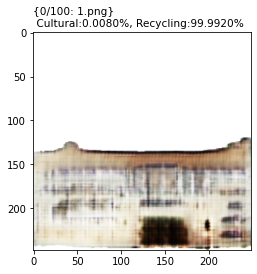

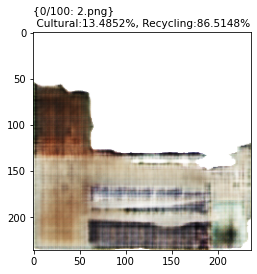

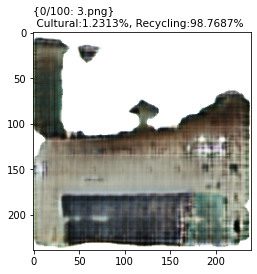

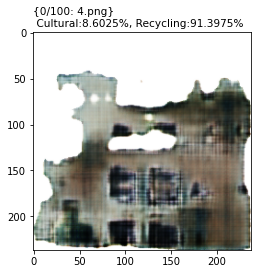

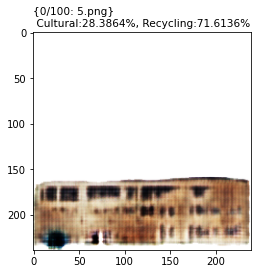

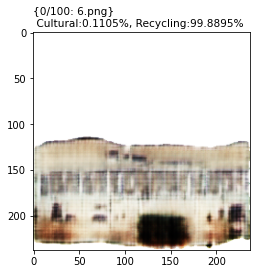

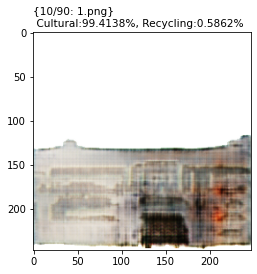

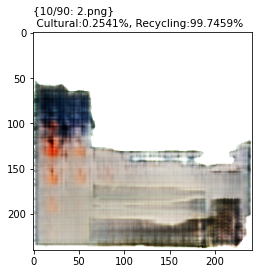

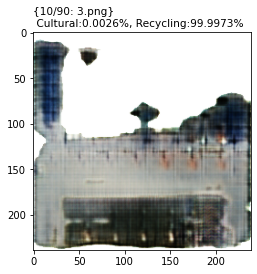

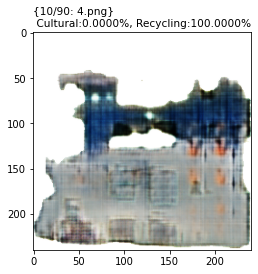

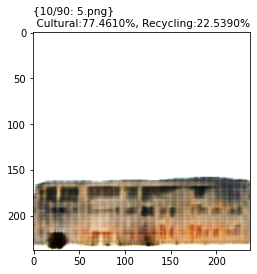

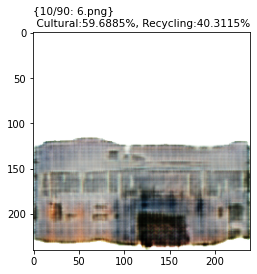

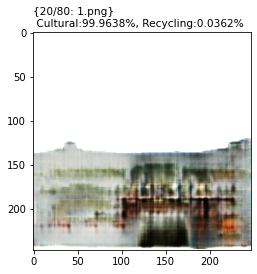

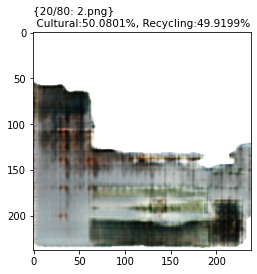

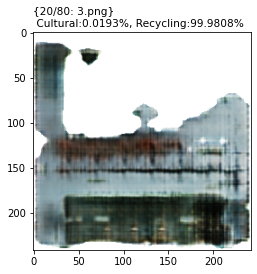

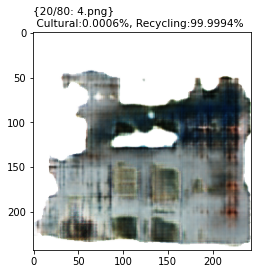

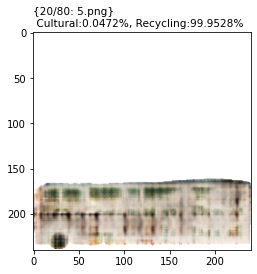

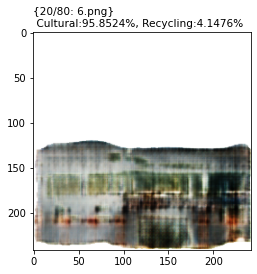

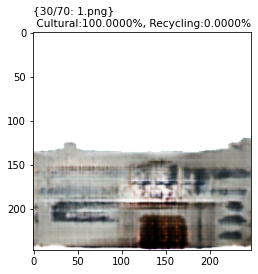

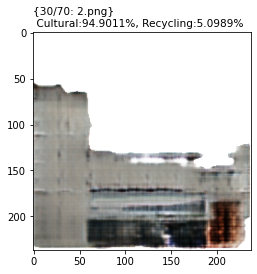

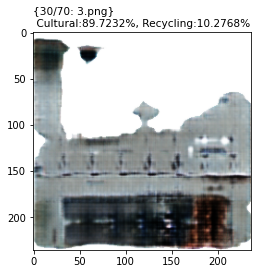

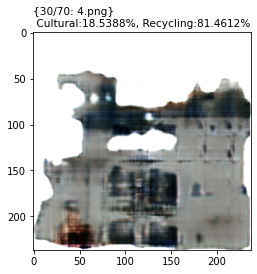

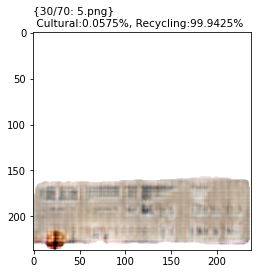

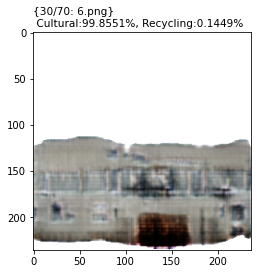

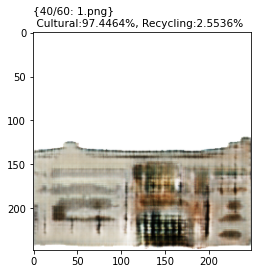

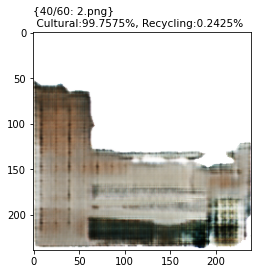

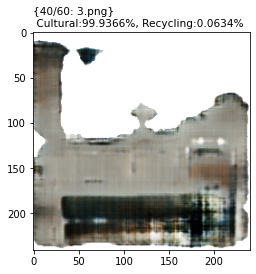

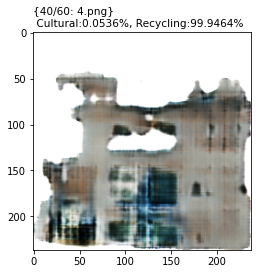

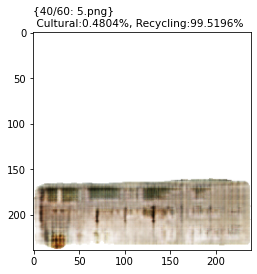

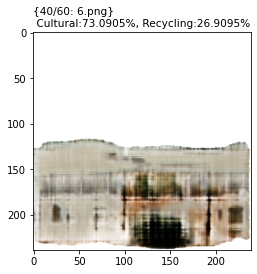

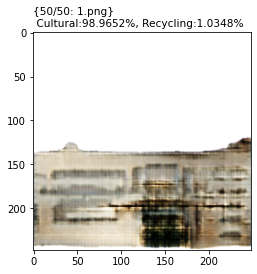

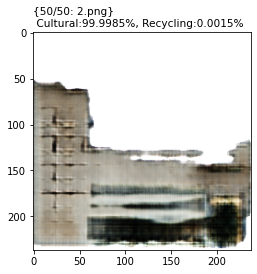

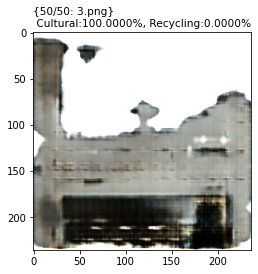

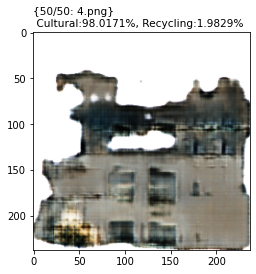

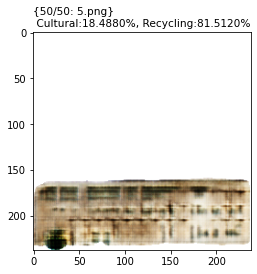

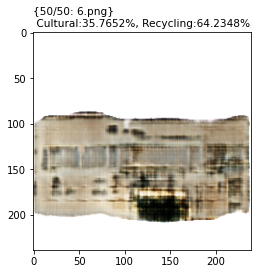

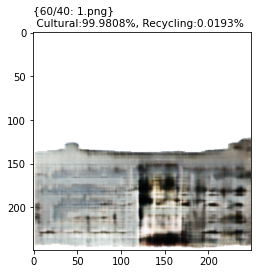

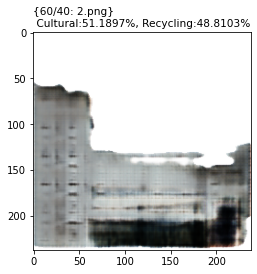

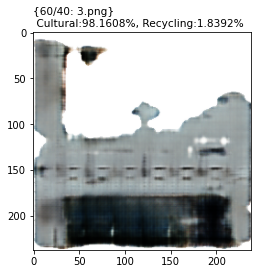

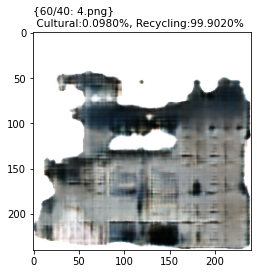

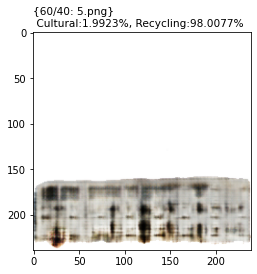

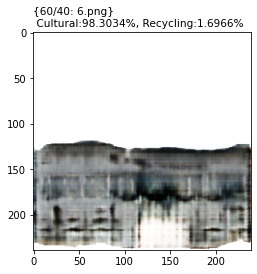

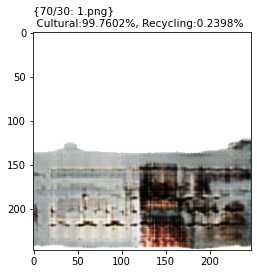

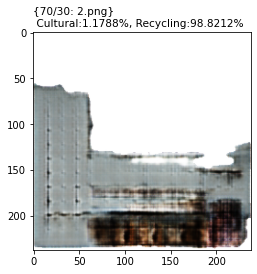

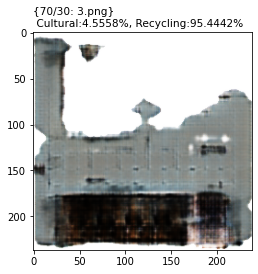

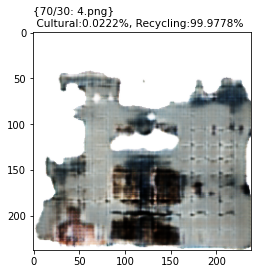

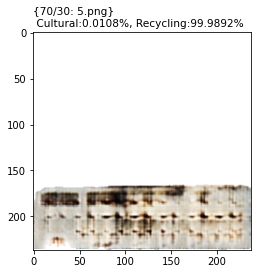

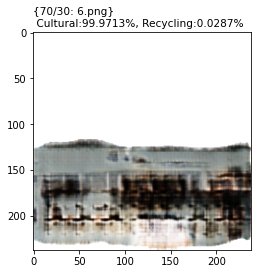

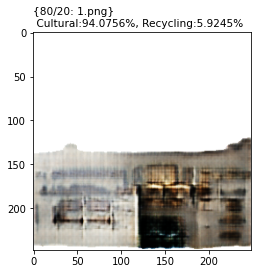

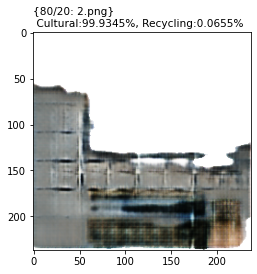

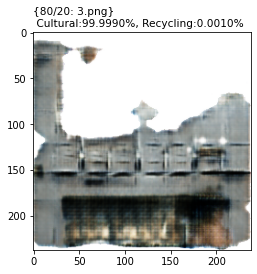

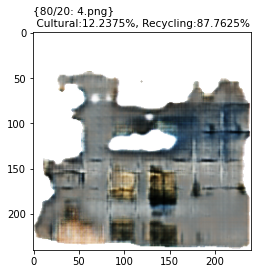

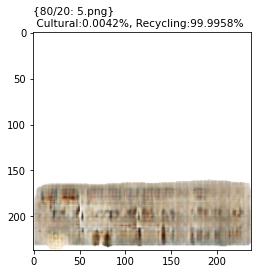

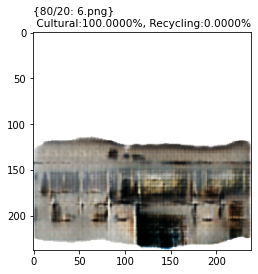

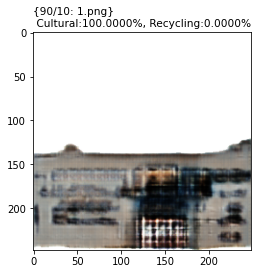

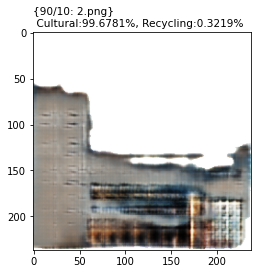

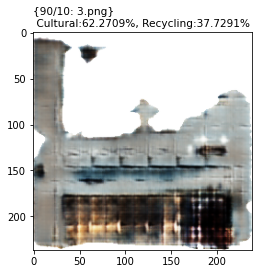

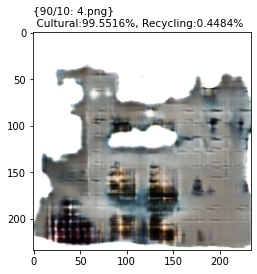

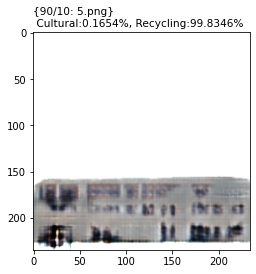

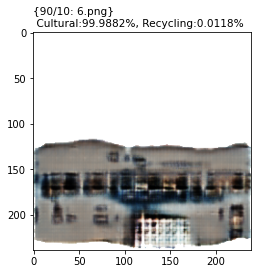

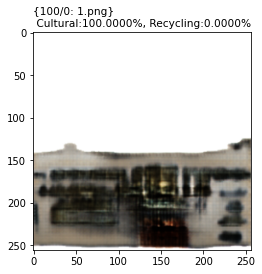

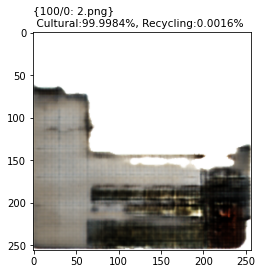

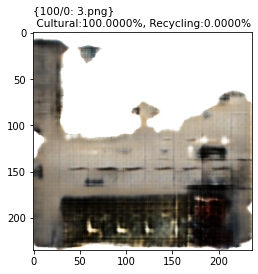

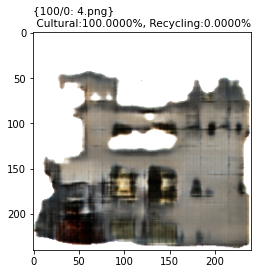

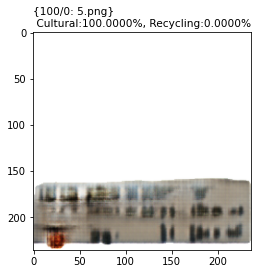

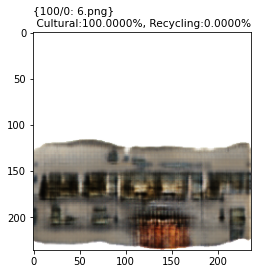

In [ ]:
for i in range(0, 110, 10):
  batch_pred(i)

###Documentation

In [ ]:
c = [] # To store probability of cultural facility
r = [] # To store probability of recycling centre

In [ ]:
for i in range(len(results)):
  splited = results[i].split(':')
  print(splited)
  #splited[]
  splited_c = splited[2].split(',')
  c.append(float(splited_c[0].replace('%', '')))
  r.append(float(splited[3].replace('%', '')))

['{0/100', ' 1.png} \n Cultural', '0.0080%, Recycling', '99.9920%']
['{0/100', ' 2.png} \n Cultural', '13.4852%, Recycling', '86.5148%']
['{0/100', ' 3.png} \n Cultural', '1.2313%, Recycling', '98.7687%']
['{0/100', ' 4.png} \n Cultural', '8.6025%, Recycling', '91.3975%']
['{0/100', ' 5.png} \n Cultural', '28.3864%, Recycling', '71.6136%']
['{0/100', ' 6.png} \n Cultural', '0.1105%, Recycling', '99.8895%']
['{10/90', ' 1.png} \n Cultural', '99.4138%, Recycling', '0.5862%']
['{10/90', ' 2.png} \n Cultural', '0.2541%, Recycling', '99.7459%']
['{10/90', ' 3.png} \n Cultural', '0.0026%, Recycling', '99.9973%']
['{10/90', ' 4.png} \n Cultural', '0.0000%, Recycling', '100.0000%']
['{10/90', ' 5.png} \n Cultural', '77.4610%, Recycling', '22.5390%']
['{10/90', ' 6.png} \n Cultural', '59.6885%, Recycling', '40.3115%']
['{20/80', ' 1.png} \n Cultural', '99.9638%, Recycling', '0.0362%']
['{20/80', ' 2.png} \n Cultural', '50.0801%, Recycling', '49.9199%']
['{20/80', ' 3.png} \n Cultural', '0.0193%

In [ ]:
grouping = []
for i in range(11):
  for j in range(6):
    #c_group.append('%03d' %  int(i*10))
    grouping.append(i*10)

In [ ]:
res_df = pd.DataFrame({'Cultural':c, 'Recycling':r, 'group':grouping})
res_df.to_csv('/content/drive/My Drive/creative_cycleland/facade/gradient/'+ str(EPOCHS) + '_analysis_result.csv')

In [ ]:
plt.figure(figsize=(30, 30)) 

fig = px.scatter(res_df,x='Cultural', y='Recycling', color=grouping)

fig.show()

<Figure size 2160x2160 with 0 Axes>